In [258]:
import os
import re
import os
import tqdm
from glob import glob
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pprint import pprint
import graphviz

from collections import defaultdict
from bs4 import BeautifulSoup

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split 
from sklearn.metrics import mean_squared_error, r2_score


In [259]:
data_path = "data/html/*.html"

code2convos = dict()

pbar = tqdm.tqdm(sorted(list(glob(data_path))))
for path in pbar:
    # print(Path.cwd() / path)
    file_code = os.path.basename(path).split(".")[0]
    with open(path, "r", encoding="latin1") as fh:
            
        # get the file id to use it as key later on
        fid = os.path.basename(path).split(".")[0]

        # read the html file
        html_page = fh.read()

        # parse the html file with bs4 so we can extract needed stuff
        soup = BeautifulSoup(html_page, "html.parser")

        # grab the conversations with the data-testid pattern
        data_test_id_pattern = re.compile(r"conversation-turn-[0-9]+")
        conversations = soup.find_all("div", attrs={"data-testid": data_test_id_pattern})

        convo_texts = []

        for i, convo in enumerate(conversations):
            convo = convo.find_all("div", attrs={"data-message-author-role":re.compile( r"[user|assistant]") })
            if len(convo) > 0:
                role = convo[0].get("data-message-author-role")
                convo_texts.append({
                        "role" : role,
                        "text" : convo[0].text
                    }
                )
                
        code2convos[file_code] = convo_texts

100%|██████████| 127/127 [00:06<00:00, 18.57it/s]


In [260]:
# let's see one of the conversations
pprint(code2convos["0031c86e-81f4-4eef-9e0e-28037abf9883"][0])

{'role': 'user',
 'text': 'Load a CSV file into a Pandas in Python. The file is named '
         "'cs412_hw1_dataset.csv' and contains columns like 'Species', "
         "'Island', 'Sex', 'Diet', 'Year', 'Life Stage', 'Body Mass (g)', "
         "'Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', and "
         "'Health Metrics'. \n"}


#### Things to do:
- Prompt matching with questions
- Feature Engineering
- Question Grades preparation
- Train/Test split
- Fitting a model for predicting the scores

#### Prompt Matching
> We want to match the prompts with the questions in the Homework Let's
> do it with a simple term frequency vectorizing method. For each prompt,
> we will come with a vector that represents it. We will do the same
> thing with each of the homework questions. Then, we will calculate the
> vectors distanance to do the matching

In [261]:
prompts = []
answers = []
code2prompts = defaultdict(list)
code2answers = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"].lower())
            user_prompts.append(conv["text"].lower()) # Adding the lower case version of the prompt
        else:
            answers.append(conv["text"].lower())
            code2answers[code].append(conv["text"].lower()) # Adding the lower case version of the answer

    code2prompts[code] = user_prompts

In [262]:

prompts = []
answers = []
code2prompts = defaultdict(list)
code2answers = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"].lower())
            user_prompts.append(conv["text"].lower()) # Adding the lower case version of the prompt
        else:
            answers.append(conv["text"].lower())
            code2answers[code].append(conv["text"].lower()) # Adding the lower case version of the answer

    code2prompts[code] = user_prompts
# mapping prompts to answers
code2prompt_answer_pairs = defaultdict(list)

for code in code2convos:
    for prompt, answer in zip(code2prompts[code], code2answers[code]):
        code2prompt_answer_pairs[code].append((prompt, answer))


code2prompt_answer_pairs["0031c86e-81f4-4eef-9e0e-28037abf9883"][0]

("load a csv file into a pandas in python. the file is named 'cs412_hw1_dataset.csv' and contains columns like 'species', 'island', 'sex', 'diet', 'year', 'life stage', 'body mass (g)', 'bill length (mm)', 'bill depth (mm)', 'flipper length (mm)', and 'health metrics'. \n",
 "you can load a csv file into a pandas dataframe in python using the pandas.read_csv() function. here's how you can do it for your specific csv file:pythoncopy codeimport pandas as pd\n\n# specify the file path\nfile_path = 'cs412_hw1_dataset.csv'\n\n# load the csv file into a pandas dataframe\ndf = pd.read_csv(file_path)\n\n# display the first few rows of the dataframe to verify the data has been loaded\nprint(df.head())\nthis code assumes that the csv file 'cs412_hw1_dataset.csv' is in the same directory as your python script or jupyter notebook. if the file is in a different directory, you can specify the full path to the file in the file_path variable.the pd.read_csv() function will automatically infer the colu

In [263]:
print(prompts[0])
print("-----------")
print(answers[0])

load a csv file into a pandas in python. the file is named 'cs412_hw1_dataset.csv' and contains columns like 'species', 'island', 'sex', 'diet', 'year', 'life stage', 'body mass (g)', 'bill length (mm)', 'bill depth (mm)', 'flipper length (mm)', and 'health metrics'. 

-----------
you can load a csv file into a pandas dataframe in python using the pandas.read_csv() function. here's how you can do it for your specific csv file:pythoncopy codeimport pandas as pd

# specify the file path
file_path = 'cs412_hw1_dataset.csv'

# load the csv file into a pandas dataframe
df = pd.read_csv(file_path)

# display the first few rows of the dataframe to verify the data has been loaded
print(df.head())
this code assumes that the csv file 'cs412_hw1_dataset.csv' is in the same directory as your python script or jupyter notebook. if the file is in a different directory, you can specify the full path to the file in the file_path variable.the pd.read_csv() function will automatically infer the column na

In [264]:
questions = [
    #####################
    """Load training dataset (5 pts)
    *  Read the .csv file with the pandas library
""",
#####################
"""Understanding the dataset & Preprocessing (15 pts)
Understanding the Dataset: (5 pts)
> - Find the shape of the dataset (number of samples & number of attributes). (Hint: You can use the **shape** function)
> - Display variable names (both dependent and independent).
> - Display the summary of the dataset. (Hint: You can use the **info** function)
> - Display the first 5 rows from training dataset. (Hint: You can use the **head** function)
Preprocessing: (10 pts)

> - Check if there are any missing values in the dataset. If there are, you can either drop these values or fill it with most common values in corresponding rows. **Be careful that you have enough data for training the  model.**

> - Encode categorical labels with the mappings given in the cell below. (Hint: You can use **map** function)
""",
"""Set X & y, split data (5 pts)

*   Shuffle the dataset.
*   Seperate your dependent variable X, and your independent variable y. The column health_metrics is y, the rest is X.
*   Split training and test sets as 80% and 20%, respectively.
""",
#####################
"""Features and Correlations (10 pts)

* Correlations of features with health (4 points)
Calculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.

* Feature Selection (3 points)
Select a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.

* Hypothetical Driver Features (3 points)
Propose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.

* __Note:__ You get can get help from GPT.
""",
#####################
"""Tune Hyperparameters (20 pts)
* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)
-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)
""",
#####################
"""Re-train and plot the decision tree with the hyperparameters you have chosen (15 pts)
- Re-train model with the hyperparameters you have chosen in part 5). (10 pts)
- Plot the tree you have trained. (5 pts)
Hint: You can import the **plot_tree** function from the sklearn library.
""",
#####################
"""Test your classifier on the test set (20 pts)
- Predict the labels of testing data using the tree you have trained in step 6. (10 pts)
- Report the classification accuracy. (2 pts)
- Plot & investigate the confusion matrix. Fill the following blanks. (8 pts)
> The model most frequently mistakes class(es) _________ for class(es) _________.
Hint: You can use the confusion_matrix function from sklearn.metrics
""",
#####################
"""Find the information gain on the first split (10 pts)""",
#####################
]


questions = [q.lower() for q in questions] # Lower case version of the questions

In [265]:
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(prompts + questions)

In [266]:
questions_TF_IDF = pd.DataFrame(vectorizer.transform(questions).toarray(), columns=vectorizer.get_feature_names_out())
questions_TF_IDF.head()

# printing the most frequent words
print("Most frequent words:")
print(questions_TF_IDF.sum().sort_values(ascending=False).head(10))


Most frequent words:
the                1.977829
pts                1.921524
you                0.925474
hyperparameters    0.734257
dataset            0.716780
split              0.636640
10                 0.605766
with               0.563605
training           0.539783
and                0.529299
dtype: float64


In [267]:

prompts = []
answers = []
code2prompts = defaultdict(list)
code2answers = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"].lower())
            user_prompts.append(conv["text"].lower()) # Adding the lower case version of the prompt
        else:
            answers.append(conv["text"].lower())
            code2answers[code].append(conv["text"].lower()) # Adding the lower case version of the answer

    code2prompts[code] = user_prompts
# mapping prompts to answers
code2prompt_answer_pairs = defaultdict(list)

for code in code2convos:
    for prompt, answer in zip(code2prompts[code], code2answers[code]):
        code2prompt_answer_pairs[code].append((prompt, answer))


code2prompt_answer_pairs["0031c86e-81f4-4eef-9e0e-28037abf9883"][0]

# Converting the dictionary to a DataFrame
refactored_data = []
for code, pairs in code2prompt_answer_pairs.items():
    vectorized_pairs = [(prompt.split(), answer.split()) for prompt, answer in pairs]
    refactored_data.append({'code': code, 'prompt_answer_pairs': vectorized_pairs})

df = pd.DataFrame(refactored_data)



,code,prompt_answer_pairs
0,0031c86e-81f4-4eef-9e0e-28037abf9883,"[([load, a, csv, file, into, a, pandas, in, py..."
1,0225686d-b825-4cac-8691-3a3a5343df2b,"[([i, have, a, dataset, that, contains, the, f..."
2,041f950b-c013-409a-a642-cffff60b9d4b,"[([i, have, a, csv, file, data, with, columns:..."
3,04f91058-d0f8-4324-83b2-19c671f433dc,"[([how, can, i, display, variable, names, in, ..."
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,"[([i, am, doing, a, machine, leraning, homewor..."


In [268]:

prompts = []
answers = []
code2prompts = defaultdict(list)
code2answers = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"].lower())
            user_prompts.append(conv["text"].lower()) # Adding the lower case version of the prompt
        else:
            answers.append(conv["text"].lower())
            code2answers[code].append(conv["text"].lower()) # Adding the lower case version of the answer

    code2prompts[code] = user_prompts
# mapping prompts to answers
code2prompt_answer_pairs = defaultdict(list)

for code in code2convos:
    for prompt, answer in zip(code2prompts[code], code2answers[code]):
        code2prompt_answer_pairs[code].append((prompt, answer))


code2prompt_answer_pairs["0031c86e-81f4-4eef-9e0e-28037abf9883"][0]

# Converting the dictionary to a DataFrame
refactored_data = []
for code, pairs in code2prompt_answer_pairs.items():
    vectorized_pairs = [(prompt.split(), answer.split()) for prompt, answer in pairs]
    refactored_data.append({'code': code, 'prompt_answer_pairs': vectorized_pairs})

df = pd.DataFrame(refactored_data)



# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# show some examples
scores.head()

,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


In [269]:

prompts = []
answers = []
code2prompts = defaultdict(list)
code2answers = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"].lower())
            user_prompts.append(conv["text"].lower()) # Adding the lower case version of the prompt
        else:
            answers.append(conv["text"].lower())
            code2answers[code].append(conv["text"].lower()) # Adding the lower case version of the answer

    code2prompts[code] = user_prompts
# mapping prompts to answers
code2prompt_answer_pairs = defaultdict(list)

for code in code2convos:
    for prompt, answer in zip(code2prompts[code], code2answers[code]):
        code2prompt_answer_pairs[code].append((prompt, answer))


code2prompt_answer_pairs["0031c86e-81f4-4eef-9e0e-28037abf9883"][0]

# Converting the dictionary to a DataFrame
refactored_data = []
for code, pairs in code2prompt_answer_pairs.items():
    vectorized_pairs = [(prompt.split(), answer.split()) for prompt, answer in pairs]
    refactored_data.append({'code': code, 'prompt_answer_pairs': vectorized_pairs})

df = pd.DataFrame(refactored_data)



# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# join the scores with the df
df = df.merge(scores, on="code")

df.head()

,code,prompt_answer_pairs,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,"[([load, a, csv, file, into, a, pandas, in, py...",48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,"[([i, have, a, dataset, that, contains, the, f...",99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,"[([i, have, a, csv, file, data, with, columns:...",90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,"[([how, can, i, display, variable, names, in, ...",97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,"[([i, am, doing, a, machine, leraning, homewor...",100.0


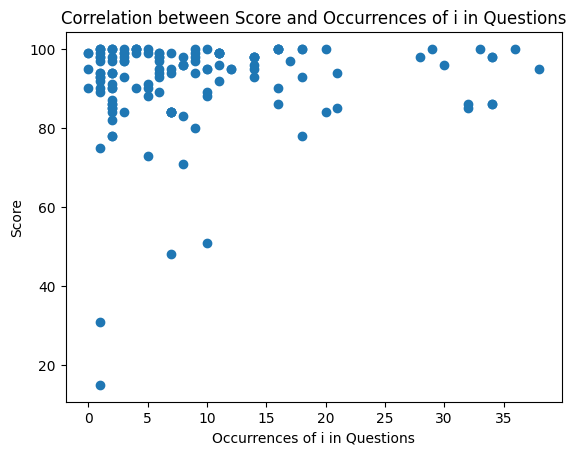

In [270]:
## CHECKING THE NUMBER OF PROMPTS THAT CONTAIN THE WORD "I"
## PLOTTING THE CORRELATION BETWEEN THE NUMBER OF "I"s AND THE SCORES
## SINCE THE PEOPLE USE "I", TENDS TO CHAT WITH GPT IN MORE DAILY LANGUAGE, IT CAN BE A GOOD INDICATOR OF THE SCORES

#define a method for see the correlation with any given word


def see_word_correlation_with_word(word):
    count_word_per_code = {}
    for row in df.itertuples():
        count_word = sum(word in prompt for prompt, _ in row.prompt_answer_pairs)
        count_word_per_code[row.code] = count_word
    df_temp = df.copy()
    df_temp['count_word'] = df_temp['code'].map(count_word_per_code)

    plt.scatter(df_temp['count_word'], df['grade'])
    plt.title("Correlation between Score and Occurrences of " + word  +" in Questions")
    plt.xlabel("Occurrences of " + word +" in Questions")
    plt.ylabel('Score')
    plt.show()

see_word_correlation_with_word("i")


In [271]:
prompts = []
answers = []
code2prompts = defaultdict(list)
code2answers = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"].lower())
            user_prompts.append(conv["text"].lower()) # Adding the lower case version of the prompt
        else:
            answers.append(conv["text"].lower())
            code2answers[code].append(conv["text"].lower()) # Adding the lower case version of the answer

    code2prompts[code] = user_prompts
# mapping prompts to answers
code2prompt_answer_pairs = defaultdict(list)

for code in code2convos:
    for prompt, answer in zip(code2prompts[code], code2answers[code]):
        code2prompt_answer_pairs[code].append((prompt, answer))


code2prompt_answer_pairs["0031c86e-81f4-4eef-9e0e-28037abf9883"][0]

# Converting the dictionary to a DataFrame
refactored_data = []
for code, pairs in code2prompt_answer_pairs.items():
    vectorized_pairs = [(prompt.split(), answer.split()) for prompt, answer in pairs]
    refactored_data.append({'code': code, 'prompt_answer_pairs': vectorized_pairs})

df = pd.DataFrame(refactored_data)



# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# join the scores with the df
df = df.merge(scores, on="code")

# adding a new column named chat_length and assign it to the size of the prompt_answer_pairs
df["chat_length"] = df["prompt_answer_pairs"].apply(lambda x: len(x))
#sort by grade
df = df.sort_values(by=["grade"], ascending=False)

df.head(50)

,code,prompt_answer_pairs,grade,chat_length
53,58fcd378-aa29-4067-813c-bb4de525428e,"[([hi., i, will, need, your, help, for, my, ma...",100.0,62
47,51f35201-da77-4b6d-a455-99cc84195c5c,"[([i, have, a, machine, learning, task., i, wa...",100.0,13
52,58bee29c-a749-463e-8d56-c4edf0815b3f,"[([before, i, get, into, the, details, of, wha...",100.0,42
55,5a62a8ee-c67c-475e-bd85-cf6d83c90ea9,"[([hello, :)], [hello!, ð, how, can, i, ass...",100.0,75
56,5a62a8ee-c67c-475e-bd85-cf6d83c90ea9,"[([hello, :)], [hello!, ð, how, can, i, ass...",100.0,75
32,36bab6e3-0d16-4626-846b-33c0384f0c79,"[([##, **goal**, *, introduction, to, the, mac...",100.0,57
128,e264c424-a241-43f7-acca-9fbbf21dc1c6,"[([how, do, i, import, pandas, library], [to, ...",100.0,35
116,c91d6fef-baf5-4e77-8bfc-b14fb7fc770d,"[([hi, chatgpt,, i, have, a, cs412, machine, l...",100.0,35
26,27de4332-d81f-47a2-b2a9-c0b023a30919,"[([selam, gpt,, machine, learning, dersi, iã§i...",100.0,21
114,c21be348-17bd-4fdd-88f5-137f6a13cdee,"[([in, python, what, was, the, function, for, ...",100.0,18


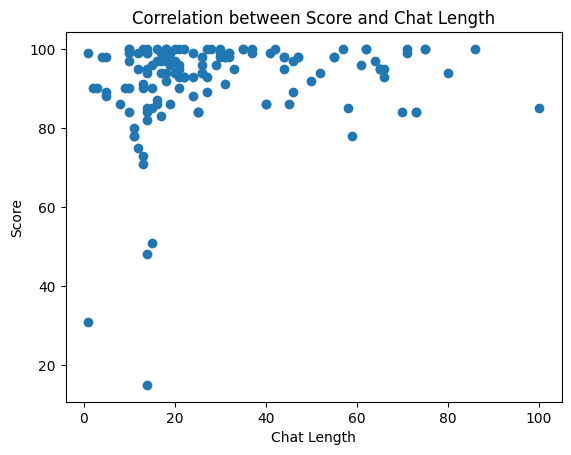

In [272]:
# now, plot the correlation between the chat length and the scores
plt.scatter(df['chat_length'], df['grade'])
plt.title('Correlation between Score and Chat Length')
plt.xlabel('Chat Length')
plt.ylabel('Score')
plt.show()

In [273]:
#read the labeled data
labeled_data_df = pd.read_csv("data/labeled_data/train_dataset.csv", sep="\t")

X_train, X_test, y_train, y_test = train_test_split(labeled_data_df["prompt"], labeled_data_df["related_question"], test_size=0.2, random_state=42)
# and then vectorize the prompts
vectorizer = TfidfVectorizer()
vectorizer = vectorizer.fit(X_train)
X_train = vectorizer.transform(X_train)
X_test = vectorizer.transform(X_test)

# train the model
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)


y_pred = clf.predict(X_test)

accuracy = clf.score(X_test, y_test)
print("Accuracy: ", accuracy)

def predict_question_number(prompt, clf):
    prompt = vectorizer.transform([prompt])
    print(clf.predict(prompt)[0])
    
labeled_data_df.head(50)


Accuracy:  1.0


,prompt,related_question
0,## 2) Load training dataset (5 pts)\n\n* Read...,1
1,## 3) Understanding the dataset & Preprocessin...,2
2,"Set X & y, split data (5 pts)\n\n* Shuffle t...",3
3,Features and Correlations (10 pts)\n\n* Correl...,4
4,Tune Hyperparameters (20 pts)\n* Choose 2 hype...,5
5,Re-train and plot the decision tree with the h...,6
6,Test your classifier on the test set (20 pts)\...,7
7,Find the information gain on the first split (...,8
8,How do I check for missing values in my dataset?,2
9,What should I do if I find missing values in m...,2


In [274]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score

labeled_data_df = pd.read_csv("data/labeled_data/train_dataset.csv", sep="\t")

labeled_data_df['prompt'] = labeled_data_df['prompt'].str.lower()

print(labeled_data_df.head())

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    labeled_data_df['prompt'],
    labeled_data_df['related_question'],
    test_size=0.2,
    random_state=42
)

# Vectorize the prompts
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

clf = MultinomialNB()
clf.fit(X_train, y_train)

# Predict the test data
y_pred = clf.predict(X_test)

# Calculate the accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: ", accuracy)

def predict_question_number(prompt, clf, vectorizer):
    prompt_vect = vectorizer.transform([prompt.lower()])
    return clf.predict(prompt_vect)[0]

new_prompt = "hi. need help machine learning class hw using palmer penguins dataset extended dataset kaggle. task build decision tree classifier."
predicted_question_number = predict_question_number(new_prompt, clf, vectorizer)
print("Predicted question number for the new prompt is:", predicted_question_number)



                                              prompt  related_question
0  ## 2) load training dataset (5 pts)\n\n*  read...                 1
1  ## 3) understanding the dataset & preprocessin...                 2
2  set x & y, split data (5 pts)\n\n*   shuffle t...                 3
3  features and correlations (10 pts)\n\n* correl...                 4
4  tune hyperparameters (20 pts)\n* choose 2 hype...                 5
Accuracy:  1.0
Predicted question number for the new prompt is: 6


In [275]:

from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Function to remove stopwords from a list of tokens
def remove_stopwords(tokens):
    return [token for token in tokens if token.lower() not in stop_words]

prompts = []
answers = []
code2prompts = defaultdict(list)
code2answers = defaultdict(list)
for code , convos in code2convos.items():
    user_prompts = []
    for conv in convos:
        if conv["role"] == "user":
            prompts.append(conv["text"].lower())
            user_prompts.append(conv["text"].lower()) # Adding the lower case version of the prompt
        else:
            answers.append(conv["text"].lower())
            code2answers[code].append(conv["text"].lower()) # Adding the lower case version of the answer

    code2prompts[code] = user_prompts
# mapping prompts to answers
code2prompt_answer_pairs = defaultdict(list)

for code in code2convos:
    for prompt, answer in zip(code2prompts[code], code2answers[code]):
        code2prompt_answer_pairs[code].append((prompt, answer))


code2prompt_answer_pairs["0031c86e-81f4-4eef-9e0e-28037abf9883"][0]

# Converting the dictionary to a DataFrame
refactored_data = []
for code, pairs in code2prompt_answer_pairs.items():
    vectorized_pairs = [(prompt.split(), answer.split()) for prompt, answer in pairs]
    refactored_data.append({'code': code, 'prompt_answer_pairs': vectorized_pairs})

df = pd.DataFrame(refactored_data)



# reading the scores
scores = pd.read_csv("data/scores.csv", sep=",")
scores["code"] = scores["code"].apply(lambda x: x.strip())

# selecting the columns we need and we care
scores = scores[["code", "grade"]]

# join the scores with the df
df = df.merge(scores, on="code")

# adding a new column named chat_length and assign it to the size of the prompt_answer_pairs
df["chat_length"] = df["prompt_answer_pairs"].apply(lambda x: len(x))
#sort by grade
df = df.sort_values(by=["grade"], ascending=False)


#init a new df from scratch
new_df = pd.DataFrame(columns=["prompt", "which_question", "grade"])

for row in df.itertuples():
    for prompt, answer in row.prompt_answer_pairs:
        #removing stop words
        prompt = remove_stopwords(prompt)
        #convert prompt to string
        promptStr = " ".join(prompt)
        #add it to a new a new df without using append
        qNo = predict_question_number(promptStr,clf,vectorizer)

        new_df.loc[len(new_df.index)] = [promptStr, qNo, row.grade]


# replace Nan values with the mean of the column for column grade
new_df["grade"].fillna((new_df["grade"].mean()), inplace=True)


In [276]:
new_df.head()

,prompt,which_question,grade
0,hi. need help machine learning class hw using ...,6,100.0
1,"great! go step step though. first, need unders...",2,100.0
2,missing percentage 7.7,2,100.0
3,thank you. filling null values encode categori...,2,100.0
4,"yes, proceed set x & y, split data. first need...",3,100.0


In [277]:
'''
grouped_df = new_df.groupby(['which_question', 'grade'])['prompt'].apply(lambda x: sum(x, [])).reset_index()

# Renaming the column to reflect that it contains combined prompts
grouped_df.rename(columns={'prompt': 'combined_prompts'}, inplace=True)

#size of the grouped df
grouped_df.head
'''

"\ngrouped_df = new_df.groupby(['which_question', 'grade'])['prompt'].apply(lambda x: sum(x, [])).reset_index()\n\n# Renaming the column to reflect that it contains combined prompts\ngrouped_df.rename(columns={'prompt': 'combined_prompts'}, inplace=True)\n\n#size of the grouped df\ngrouped_df.head\n"

In [278]:
'''
Q1: 5pt
Q2: 15PT
Q3: 5PT
Q4: 10PT
Q5: 20PT
Q6: 15PT
Q7: 20PT
Q8: 10PT
'''

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(), 'prompt'),
        ('std_scaler', StandardScaler(), ['which_question'])
    ]
)

# Create a pipeline with preprocessing and a regressor
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor())
])

# Split the data into training and testing sets
X = new_df[['prompt', 'which_question']]
y = new_df['grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

new_prompt = 'Could you provide some examples of the hyperparameters you chose to tune for the decision tree model, and explain why they are important for model performance?'
question_number = predict_question_number(new_prompt, clf, vectorizer)
print(f'The predicted question number for the prompt is: {question_number}')
predicted_grade = pipeline.predict(pd.DataFrame({'prompt': [new_prompt], 'which_question': [question_number]}))

print(f'The predicted grade for the prompt "{new_prompt}" for question {question_number} is: {predicted_grade[0]}')



Mean Squared Error: 69.31190580782986
Root Mean Squared Error: 8.325377217149374
Mean Absolute Error: 4.870619249561103
R-squared: -0.021595088740274493
The predicted question number for the prompt is: 5
The predicted grade for the prompt "Could you provide some examples of the hyperparameters you chose to tune for the decision tree model, and explain why they are important for model performance?" for question 5 is: 94.93333333333332


In [279]:
########## deneme 2
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import make_pipeline
import joblib # To save models for later use
def train_models_per_question(new_df):
    models = {}
    evaluation = {}
    for question_number in new_df['which_question'].unique():
        # Segment the data by question number
        question_data = new_df[new_df['which_question'] == question_number]

        # Split the data into features and target
        X = question_data['prompt']
        y = question_data['grade']

        # Split into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        # Create a text processing and regression pipeline
        pipeline = make_pipeline(TfidfVectorizer(), LinearRegression())

        # Train the model
        pipeline.fit(X_train, y_train)

        # Evaluate the model
        y_pred = pipeline.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)

        # Save the model and its evaluation
        models[question_number] = pipeline
        evaluation[question_number] = {'MSE': mse, 'R2': r2}

        # Save models to disk (optional)
        joblib.dump(pipeline, f'model_question_{question_number}.joblib')

    return models, evaluation

models, evaluation = train_models_per_question(new_df)

In [281]:
def test_model(prompt, question_number, models):
    # Check if the model for the given question number exists
    if question_number in models:
        # Predict the grade for the given prompt
        predicted_grade = models[question_number].predict([prompt])[0]
        return predicted_grade
    else:
        raise ValueError(f"No model found for question number {question_number}.")

In [319]:
########### DENEME 3

def predict_with_similarity_adjustment(prompt, question_number, models, new_df):
    prompt = prompt.lower()
    #removing the stopwords
    prompt = remove_stopwords(prompt.split())
    #convert prompt to string
    prompt = " ".join(prompt)

    # Retrieve the model pipeline for the given question number
    pipeline = models.get(question_number)
    if not pipeline:
        raise ValueError(f"No model found for question number {question_number}.")

    # Get the vectorizer from the pipeline
    vectorizer = pipeline.named_steps['tfidfvectorizer']
    model = pipeline.named_steps['linearregression']

    # Transform the new prompt into TF-IDF vector
    prompt_vector = vectorizer.transform([prompt])

    # Transform the training data prompts into TF-IDF vectors
    train_vectors = vectorizer.transform(new_df[new_df['which_question'] == question_number]['prompt'])

    # Compute cosine similarities
    similarities = cosine_similarity(prompt_vector, train_vectors)
    
    # Find the maximum similarity score
    max_similarity = np.max(similarities)

    # Predict the score using the regression model
    predicted_score = model.predict(prompt_vector)[0]

    # Adjust the predicted score based on similarity
    adjusted_score = predicted_score * max_similarity

    return adjusted_score, max_similarity


new_prompt = 'Tune Hyperparameters (20 pts)* Choose 2 hyperparameters to tune. You can use the Scikit learn decision tree documentation for the available hyperparameters *(Hyperparameters are listed under "Parameters" in the documentation)*. Use GridSearchCV for hyperparameter tuning, with a cross-validation value of 5. Use validation accuracy to pick the best hyper-parameter values. (15 pts)-Explain the hyperparameters you chose to tune. *(What are the hyperparameters you chose? Why did you choose them?)* (5 pts)'
question_number = predict_question_number(new_prompt, clf, vectorizer)
print(f'The predicted question number for the prompt is: {question_number}')

predicted_score, max_similarity = predict_with_similarity_adjustment(new_prompt, question_number, models, new_df)
print("predicted score is: ", predicted_score)



The predicted question number for the prompt is: 5
predicted score is:  93.41453216100302


In [293]:
new_prompt = 'Could you provide some examples of the hyperparameters you chose to tune for the decision tree model, and explain why they are important for model performance?'
question_number = predict_question_number(new_prompt, clf, vectorizer)
print(f'The predicted question number for the prompt is: {question_number}')
test_model(new_prompt, 1, models)

The predicted question number for the prompt is: 5


103.627561676792

In [ ]:
code2prompts_tf_idf = dict()
for code, user_prompts in code2prompts.items():
    if len(user_prompts) == 0:
        # some files have issues
        print(code+".html")
        continue
    prompts_TF_IDF = pd.DataFrame(vectorizer.transform(user_prompts).toarray(), columns=vectorizer.get_feature_names_out())
    code2prompts_tf_idf[code] = prompts_TF_IDF

139235c7-736c-4237-92f0-92e8c116832c.html
668ad17e-0240-49f7-b5a7-d22e502554c6.html
b0640e51-6879-40cb-a4f5-329f952ef99d.html
da6b70d5-29f6-491a-ad46-037c77067128.html


In [29]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].head()

,00000,000000,000196,000282,000284,000360,000469,000750,000886,000991,...,yticks,yã,yä,zaman,zdã¼m,zero,zerodivisionerror,zeroth,zip,ã¼nã¼yorum
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
code2prompts_tf_idf["089eb66d-4c3a-4f58-b98f-a3774a2efb34"].shape

(86, 5400)

In [31]:
code2cosine = dict()
for code, user_prompts_tf_idf in code2prompts_tf_idf.items():
    code2cosine[code] = pd.DataFrame(cosine_similarity(questions_TF_IDF,user_prompts_tf_idf))

In [32]:
questions[4]

"Features and Correlations (10 pts)\n\n* Correlations of features with health (4 points)\nCalculate the correlations for all features in dataset. Highlight any strong correlations with the target variable. Plot your results in a heatmap.\n\n* Feature Selection (3 points)\nSelect a subset of features that are likely strong predictors, justifying your choices based on the computed correlations.\n\n* Hypothetical Driver Features (3 points)\nPropose two hypothetical features that could enhance the model's predictive accuracy for Y, explaining how they might be derived and their expected impact. Show the resulting correlations with target variable.\n\n* __Note:__ You get can get help from GPT.\n"

In [33]:
code2questionmapping = dict()
for code, cosine_scores in code2cosine.items():
    code2questionmapping[code] = code2cosine[code].max(axis=1).tolist()


question_mapping_scores = pd.DataFrame(code2questionmapping).T
question_mapping_scores.reset_index(inplace=True)
question_mapping_scores.rename(columns={i: f"Q_{i}" for i in range(len(questions))}, inplace=True)
question_mapping_scores.rename(columns={"index" : "code"}, inplace=True)

question_mapping_scores

,code,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769
...,...,...,...,...,...,...,...,...,...,...
118,f24219d6-07f0-4baf-80ac-18475dc5b66f,0.187393,0.209889,0.358875,0.211246,0.149281,0.507128,1.000000,0.862585,0.739634
119,f2f18684-4a16-4c05-a2d1-c0f96d1de869,0.144760,0.139495,0.332267,0.950344,0.775698,0.828355,0.374145,0.905688,0.553341
120,f852596d-fdca-45aa-9050-d4f76ce6a53c,0.211008,0.908697,0.977725,0.924311,0.888609,0.921306,0.779558,0.767328,0.499508
121,f8ec3336-fd48-4654-ad98-62ccfb96d096,0.173215,0.967321,1.000000,0.703987,0.942662,0.907417,1.000000,1.000000,0.782938


# Feature Engineering
- Number of prompts that a uers asked
- Number of complaints that a user makes e.g "the code gives this error!"
- User prompts average number of characters

In [35]:
code2features = defaultdict(lambda : defaultdict(int))

keywords2search = ["error", "no", "thank", "next", "Entropy"]
keywords2search = [k.lower() for k in keywords2search]

for code, convs in code2convos.items():
    if len(convs) == 0:
        print(code)
        continue
    for c in convs:
        text = c["text"].lower()
        if c["role"] == "user":
            # User Prompts

            # count the user prompts
            code2features[code]["#user_prompts"] += 1
            
            # count the keywords
            for kw in keywords2search:
                code2features[code][f"#{kw}"] +=  len(re.findall(rf"\b{kw}\b", text))

            code2features[code]["prompt_avg_chars"] += len(text)
        else:
            # ChatGPT Responses
            code2features[code]["response_avg_chars"] += len(text)

        code2features[code]["prompt_avg_chars"] /= code2features[code]["#user_prompts"]   
        code2features[code]["response_avg_chars"] /= code2features[code]["#user_prompts"]

139235c7-736c-4237-92f0-92e8c116832c
668ad17e-0240-49f7-b5a7-d22e502554c6
b0640e51-6879-40cb-a4f5-329f952ef99d
da6b70d5-29f6-491a-ad46-037c77067128


In [36]:
df = pd.DataFrame(code2features).T
df.head(5)

,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370
0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582
041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601
04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566
089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913


,code,grade
0,6a2003ad-a05a-41c9-9d48-e98491a90499,90.0
1,04f91058-d0f8-4324-83b2-19c671f433dc,97.0
2,81fdeb2a-e7e5-4a05-8058-d31ea579b0d9,94.0
3,6a903495-c5be-4263-b4dd-75e2bbc30434,97.0
4,6d5742c1-77c4-429c-8f6e-ef1262ca5557,93.0


Correlation between average prompt length and score: -0.17884652195686737


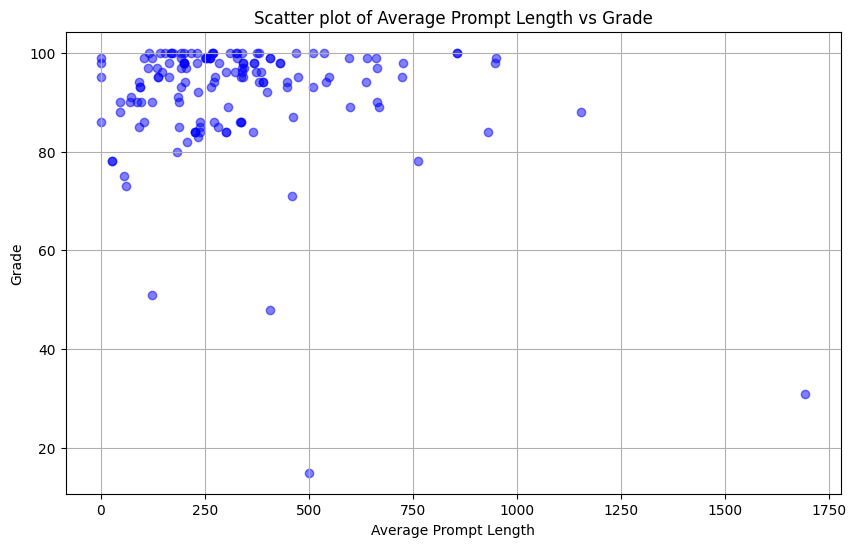

In [64]:
## Checking out if there is correlation between the average length of the conversation and the score
avg_prompt_lengths = {}

for code, prompts in code2prompts.items():
    if prompts: 
        avg_length = sum(len(prompt) for prompt in prompts) / len(prompts)
    else:
        avg_length = 0
    avg_prompt_lengths[code] = avg_length


lengths_df = pd.DataFrame(list(avg_prompt_lengths.items()), columns=['code', 'avg_prompt_length'])
merged_df = pd.merge(scores, lengths_df, on='code')

correlation = merged_df['grade'].corr(merged_df['avg_prompt_length'])
print(f"Correlation between average prompt length and score: {correlation}")

plt.figure(figsize=(10, 6))
plt.scatter(merged_df['avg_prompt_length'], merged_df['grade'], color='blue', alpha=0.5)
plt.title('Scatter plot of Average Prompt Length vs Grade')
plt.xlabel('Average Prompt Length')
plt.ylabel('Grade')
plt.grid(True)
plt.show()


Correlation between number of prompts and score: 0.17652811996824117


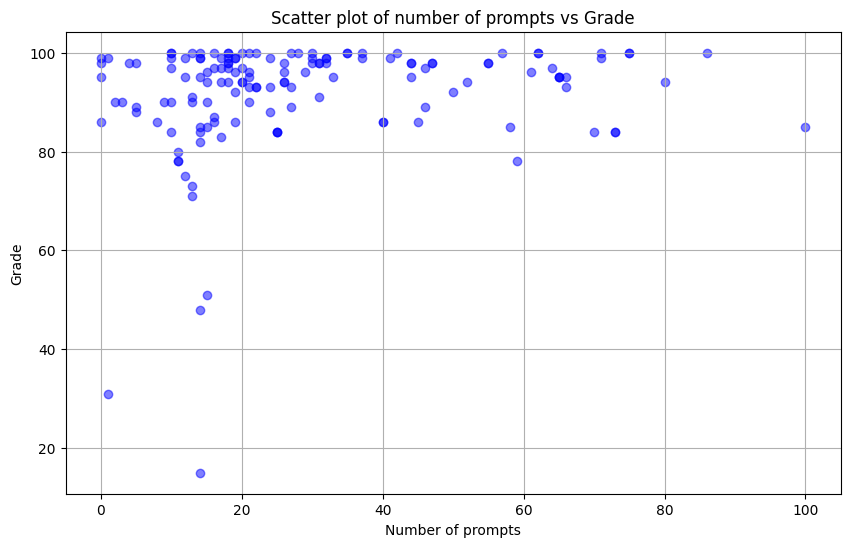

In [71]:
# Checking if the number of prompts has any correlation with the score

num_prompts = {}

for code, prompts in code2prompts.items():
    num_prompts[code] = len(prompts)


numPromptsDF = pd.DataFrame(list(num_prompts.items()), columns=['code', 'num_prompts'])
merged_df = pd.merge(scores, numPromptsDF, on='code')

correlation = merged_df['grade'].corr(merged_df['num_prompts'])
print(f"Correlation between number of prompts and score: {correlation}")

plt.figure(figsize=(10, 6))
plt.scatter(merged_df['num_prompts'], merged_df['grade'], color='blue', alpha=0.5)
plt.title('Scatter plot of number of prompts vs Grade')
plt.xlabel('Number of prompts')
plt.ylabel('Grade')
plt.grid(True)
plt.show()

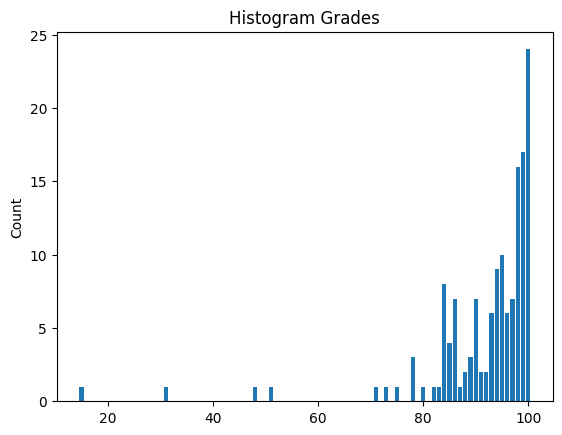

In [41]:
# Let's check grades distribution

plt.title('Histogram Grades')
plt.hist(scores["grade"], rwidth=.8, bins=np.arange(min(scores["grade"]), max(scores["grade"])+2) - 0.5)
plt.ylabel('Count')
plt.show()

In [51]:
df.reset_index(inplace=True, drop=False)
df.rename(columns={"index": "code"}, inplace=True)
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913


In [52]:
df = pd.merge(df, question_mapping_scores, on="code", how="left")
df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769


#### Merging scores with features

In [53]:
temp_df = pd.merge(df, scores, on='code', how="left")
temp_df.dropna(inplace=True)
temp_df.drop_duplicates("code",inplace=True, keep="first")
temp_df.head()

,code,#user_prompts,#error,#no,#thank,#next,#entropy,prompt_avg_chars,response_avg_chars,Q_0,Q_1,Q_2,Q_3,Q_4,Q_5,Q_6,Q_7,Q_8,grade
0,0031c86e-81f4-4eef-9e0e-28037abf9883,14.0,3.0,1.0,0.0,0.0,0.0,2.205748,212.206370,0.153541,0.294879,0.522169,0.352243,0.460606,0.553876,0.167250,0.182938,0.195440,48.0
1,0225686d-b825-4cac-8691-3a3a5343df2b,18.0,0.0,0.0,0.0,0.0,3.0,0.304163,113.633582,0.192013,0.795607,0.772184,0.882656,0.607114,0.987511,0.892586,0.570741,0.543866,99.0
2,041f950b-c013-409a-a642-cffff60b9d4b,9.0,3.0,0.0,1.0,0.0,3.0,0.262324,17.187601,0.258306,0.295923,0.624824,0.351872,0.643038,0.454314,0.540269,0.546506,0.325793,90.0
3,04f91058-d0f8-4324-83b2-19c671f433dc,20.0,1.0,1.0,0.0,0.0,3.0,0.123346,107.092566,0.145965,0.117841,0.267346,0.316809,0.333889,0.309084,0.192434,0.261892,0.407106,97.0
4,089eb66d-4c3a-4f58-b98f-a3774a2efb34,86.0,1.0,5.0,0.0,0.0,26.0,0.017986,18.850913,0.344182,0.575528,0.782883,0.624833,0.724872,0.872171,0.684797,0.945305,0.511769,100.0


In [54]:
X = temp_df[temp_df.columns[1:-1]].to_numpy()
y = temp_df["grade"].to_numpy()
print(X.shape, y.shape)

(122, 17) (122,)


#### Train/Test split

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("Train set size:", len(X_train))
print("Test set size:", len(X_test))

Train set size: 97
Test set size: 25


#### Fitting a model

#### Predicting and Analyzing 

In [56]:
regressor = DecisionTreeRegressor(random_state=0,criterion='squared_error', max_depth=10)
regressor.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

In [57]:
extracted_MSEs = regressor.tree_.impurity   
for idx, MSE in enumerate(regressor.tree_.impurity):
    print("Node {} has MSE {}".format(idx,MSE))

Node 0 has MSE 163.42034222552866
Node 1 has MSE 126.39409722222263
Node 2 has MSE 64.35004526935154
Node 3 has MSE 167.02777777777737
Node 4 has MSE 83.96484375
Node 5 has MSE 51.6875
Node 6 has MSE 0.0
Node 7 has MSE 10.489795918369055
Node 8 has MSE 0.6666666666660603
Node 9 has MSE 0.0
Node 10 has MSE 0.25
Node 11 has MSE 0.0
Node 12 has MSE 0.0
Node 13 has MSE 0.0
Node 14 has MSE 54.359375
Node 15 has MSE 1.0
Node 16 has MSE 0.0
Node 17 has MSE 0.0
Node 18 has MSE 26.58333333333303
Node 19 has MSE 12.6875
Node 20 has MSE 4.66666666666697
Node 21 has MSE 0.25
Node 22 has MSE 0.0
Node 23 has MSE 0.0
Node 24 has MSE 0.0
Node 25 has MSE 0.0
Node 26 has MSE 9.0
Node 27 has MSE 0.0
Node 28 has MSE 0.0
Node 29 has MSE 100.0
Node 30 has MSE 0.0
Node 31 has MSE 0.0
Node 32 has MSE 27.533240997230678
Node 33 has MSE 25.170927684439448
Node 34 has MSE 22.85062487601499
Node 35 has MSE 6.888888888887777
Node 36 has MSE 0.25
Node 37 has MSE 0.0
Node 38 has MSE 0.0
Node 39 has MSE 0.0
Node 40 h

In [58]:
# Plotting the Tree 
dot_data = tree.export_graphviz(regressor, out_file=None, feature_names=temp_df.columns[1:-1])
graph = graphviz.Source(dot_data)
graph.render("hw")

'hw.pdf'

In [59]:
# Prediction
y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

# Calculation of Mean Squared Error (MSE)
print("MSE Train:", mean_squared_error(y_train,y_train_pred))
print("MSE TEST:", mean_squared_error(y_test,y_test_pred))

print("R2 Train:", r2_score(y_train,y_train_pred))
print("R2 TEST:", r2_score(y_test,y_test_pred))


MSE Train: 8.279086892488953
MSE TEST: 101.55122448979591
R2 Train: 0.9493387005574656
R2 TEST: 0.09543774326422416
